# Create and visualize disease similarity and proximity networks 

In [1]:
import pandas
import numpy
import networkx
import matplotlib.pyplot as plt

%matplotlib inline

## Merge similarity and proximity scores into a single dataframe

In [2]:
dice_df = pandas.read_table('data/disease-similarity.tsv', index_col=0)
similarity_df = pandas.melt(dice_df.reset_index(), id_vars='doid_id')
similarity_df.columns = ['source_id', 'target_id', 'similarity']
prox_df = pandas.read_table('data/proximities.tsv')
network_df = prox_df.merge(similarity_df)

In [3]:
def consolidate(df):
    series = df.iloc[0, :].copy()
    for column in 'proximity', 'similarity':
        series[column] = df[column].mean()
    return series

by_map = network_df.apply(lambda x: frozenset([x.source_id, x.target_id]), axis=1)
network_df = network_df.groupby(by_map).apply(consolidate)

In [4]:
network_df.to_csv('data/network.tsv', sep='\t', index=False, float_format='%.6f')
network_df.head(5)

,source_id,source_name,target_id,target_name,proximity,similarity
"(DOID:12306, DOID:8577)",DOID:8577,ulcerative colitis,DOID:12306,vitiligo,0.016136,0.000000
"(DOID:1936, DOID:10652)",DOID:10652,Alzheimer's disease,DOID:1936,atherosclerosis,0.141439,0.032741
"(DOID:1107, DOID:10652)",DOID:10652,Alzheimer's disease,DOID:1107,esophageal carcinoma,0.069386,0.033051
"(DOID:10286, DOID:10652)",DOID:10652,Alzheimer's disease,DOID:10286,prostate carcinoma,0.050564,0.016684
"(DOID:10652, DOID:10871)",DOID:10652,Alzheimer's disease,DOID:10871,age related macular degeneration,0.044876,0.000000


In [5]:
%%capture
# Create html table browswer
! R -e "rmarkdown::render('tables.Rmd')"

## Construct and plot networkx Graphs

In [6]:
# normalize metrics to have mean of 1 for weighted layout
for column in 'proximity', 'similarity':
    network_df[column] /= network_df[column].mean()

In [7]:
g_sim = networkx.Graph(name='similarity')
g_prox = networkx.Graph(name='proximity')

for i, row in network_df.iterrows():
    for column, graph in ('similarity', g_sim), ('proximity', g_prox):
        weight = row[column]
        if weight == 0:
            continue
        graph.add_edge(row.source_id, row.target_id, weight=weight)
        graph.node[row.source_id]['name'] = row.source_name
        graph.node[row.target_id]['name'] = row.target_name

for graph in g_sim, g_prox:
    print(networkx.info(graph), '\n')

Name: similarity
Type: Graph
Number of nodes: 82
Number of edges: 433
Average degree:  10.5610 

Name: proximity
Type: Graph
Number of nodes: 82
Number of edges: 3321
Average degree:  81.0000 



In [8]:
# Check whether the similarity network is connected
assert networkx.is_connected(g_sim)

In [9]:
# Manual node colors
color_df = pandas.DataFrame(list({
    'Autoimmune': '#998EC3',
    'Solid Cancer': '#F1A340',
    'Hematologic Cancer': '#F7F7F7',
    numpy.nan: '#D8D8D8'
}.items()), columns=['category', 'color'])

# Read manual disease categorizations
category_df = pandas.read_table('input/doid-categories.tsv')
category_df = category_df.merge(color_df)
category_df = category_df[category_df.doid_code.isin(g_sim.nodes())]

# MS set as special color
category_df.loc[category_df.doid_name == 'multiple sclerosis', 'color'] = '#423869'

# List of nodes to plot
nodelist = list(category_df.doid_code)

# Dictionary of nodes to label
label_dict_white = {row.doid_code: row.abbreviation for i, row in category_df.iterrows() if
                    row.category in {'Autoimmune', 'Solid Cancer'}}
label_dict_black = {row.doid_code: row.abbreviation for i, row in category_df.iterrows() if
                    row.category == 'Hematologic Cancer'}

In [10]:
def initially_position(nodes, seed=None):
    """
    Randomly generate initial positions for networkx nodes.
    Useful if setting the random seed to enable reproducible
    layouts.
    """
    numpy.random.seed(seed)
    rand_pos = numpy.random.ranf((len(nodes), 2))
    return {k: tuple(v) for k, v in zip(nodes, rand_pos)}

## Plot the similarity network

/Users/dhimmels/anaconda3/lib/python3.4/site-packages/networkx/drawing/layout.py:269: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if pos==None:


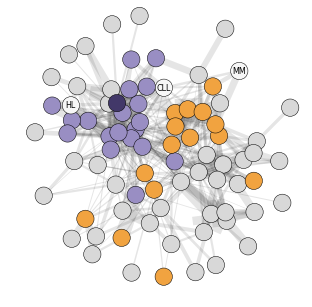

In [11]:
plt.figure(figsize=(5, 5))
plt.axis('off')

positions = initially_position(nodelist, 1)
positions = networkx.spring_layout(g_sim, pos=positions, weight='weight', iterations=500, k = 1.8 * len(g_sim)**-0.5)
networkx.draw_networkx_nodes(g_sim, pos=positions, nodelist=nodelist, node_color=category_df.color, linewidths=0.5)
for u, v, data in g_sim.edges(data=True):
    networkx.draw_networkx_edges(g_sim, pos=positions, alpha=0.1, edgelist=[(u, v)], width=data['weight'] / 2)
networkx.draw_networkx_labels(g_sim, pos=positions, labels=label_dict_black, font_size=8);
plt.xlim((-0.035, 1.035))
plt.ylim((-0.035, 1.035))
plt.savefig('figure/similarity-network.svg', bbox_inches='tight')
plt.savefig('figure/similarity-network.png', dpi=450, bbox_inches='tight')

## Plot the proximity network

/Users/dhimmels/anaconda3/lib/python3.4/site-packages/networkx/drawing/layout.py:269: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if pos==None:


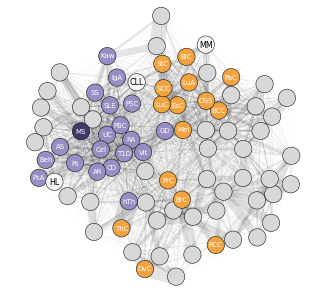

In [12]:
plt.figure(figsize=(5, 5))
plt.axis('off')
positions = initially_position(nodelist, 1)
positions = networkx.spring_layout(g_prox, pos=positions, weight='weight', iterations=500,  k = 3 * len(g_sim)**-0.5)
networkx.draw_networkx_nodes(g_prox, pos=positions, nodelist=list(category_df.doid_code), node_color=category_df.color, linewidths=0.5)
for u, v, data in g_prox.edges(data=True):
    networkx.draw_networkx_edges(g_sim, pos=positions, alpha=0.1, edgelist=[(u, v)], width=data['weight'] / 2)
networkx.draw_networkx_labels(g_sim, pos=positions, labels=label_dict_black, font_size=8, font_color='black');
networkx.draw_networkx_labels(g_sim, pos=positions, labels=label_dict_white, font_size=7, font_color='white');
plt.xlim((-0.035, 1.035))
plt.ylim((-0.035, 1.035))
plt.savefig('figure/proximity-network.svg', bbox_inches='tight')
plt.savefig('figure/proximity-network.png', dpi=450, bbox_inches='tight')